# "Finding a Norwegian language dataset for sentiment analysis"
> "In this post I'll try to find a Norwegian language dataset suitable for sentiment analysis. This dataset will be used in the upcoming posts to test various deep learning methods such as ULMFiT and MultiFiT. I will also experiment with the fastai2 deep learning library."
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [NLP, fastai, ]
- image: images/some_folder/your_image.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

I'm currently taking the fast.ai online course practical deep learning for coders (to be released publicly in July 2020). As part of the studies I want to explore the fastai2 deep learning library. I will do so by testing various NLP methods.

Over the next few posts I'll got through the entire process of finding and processing data, training various models and also interpret the results. I'll try to highlight the various things I've been struggling with or confused about. I think writing short blog posts such as these are a great way of learning new material.

## The NOREC dataset

I wanted to find a dataset in my native Norwegian to analyze. NLP for languages other than English is often challenging, even though many new techniques are addressing this. After a bit of searching I found the [Norec dataset](https://github.com/ltgoslo/norec). It contains Norwegian language reviews of various films, music etc. The dataset even comes with a [paper](http://www.lrec-conf.org/proceedings/lrec2018/pdf/851.pdf) that explains the setup of the data! This seems like a great case study, and is similar to the IMDB movie review sentiment analyses, which is one of the built in datasets of the fastai2 library.

The repo includes a utility library and a download.sh script. This is what you normally would want to use to ease the process of actually getting the data, but in this case I would like to do things manually. We'll be using the fastai2 library (which upon release will be renamed to fastai).  

Note that `import *` is usually not encouraged, but the fastai2 library has defined it's \_\_all__ variable properly, so this won't be a problem. Libraries such as pandas and numpy are part of the import.

In [1]:
from fastai2.text.all import *

I'm using fastai2 '0.0.17' and fastcore '0.1.17'. To check the version you can uncomment the following lines:

In [2]:
#collapse
# import fastai2, fastcore
# fastai2.__version__, fastcore.__version__

First we'll download and extract the data from the `url` given in the download.sh file in the github-repo to a `dest` with `archive_name`. Note the `!command` syntax which runs the corresponding wget shell command. The wget command only has to be run once.

In [3]:
url = f'http://folk.uio.no/eivinabe/norec-1.0.1.tar.gz'
data_path = Path('/data/hgi/.fastai')
dest = data_path/'archive'
archive_name = 'norec.tar.gz'
!wget {url} -O {dest/archive_name} -q

Then we'll extract the archive with the tarfile library (imported via the fastai2 import at the beginning of the notebook). We'll extract from the archive location to `data`. Finally we set a new `path` that points to this location.

In [4]:
tarfile.open(dest/archive_name).extractall(data_path/'data')
path = data_path/'data/norec'
Path.BASE_PATH=path # this avoids printing the entire file-path when we list files in a directory
path.ls()

(#4) [Path('metadata.json'),Path('conllu.tar.gz'),Path('html.tar.gz'),Path('README.txt')]

The archive contains a .json file with metadata, and among other, a html.tar.gz archive with our desired raw texts. We'll 
extract this archive too. The conllu.tar.gz contains tokenized and filtered text, and we don't need this for the time being.

In [5]:
tarfile.open(path/'html.tar.gz').extractall(path)
path.ls()

(#5) [Path('metadata.json'),Path('conllu.tar.gz'),Path('html.tar.gz'),Path('html'),Path('README.txt')]

The extracted archive is now in the `data/norec/html` folder, which contains the train, dev (we'll call it validation) and test split.

In [6]:
(path/'html').ls()

(#3) [Path('html/train'),Path('html/test'),Path('html/dev')]

## Inspect the metadata

Let's inspect the metatdata file and see if we are able to make sense of the data. But what does this json file look like? We can use the `head` command to have a look at the raw file contents before we attempt to read it into a pandas dataframe:

In [7]:
!head -n 20 {path/'metadata.json'}

{
  "000000": {
    "authors": [
      "Birger Vestmo"
    ],
    "category": "screen",
    "day": 27,
    "excerpt": "Toppen innen tv-drama akkurat nå!",
    "id": 0,
    "language": "nb",
    "month": 9,
    "rating": 6,
    "source": "p3",
    "source-category": "tv",
    "source-id": 74781,
    "source-tags": [],
    "split": "train",
    "tags": [
      "tv"
    ],


Let's try to read the data with pandas default `read_json()`

In [8]:
pd.read_json(path/'metadata.json').head(3)

,0,1,2,3,4,5,6,7,8,9,...,705136,705137,705138,705139,705140,705141,705142,705143,705144,705145
authors,[Birger Vestmo],[Birger Vestmo],[Birger Vestmo],[Birger Vestmo],[Birger Vestmo],[Torfinn Borkhus],[Torfinn Borkhus],[Torfinn Borkhus],[Torfinn Borkhus],[Torfinn Borkhus],...,[Arnfinn Bø-Rygg],[Leif Tore Lindø],[Leif Tore Lindø],[Kine Hult],[Arnfinn Bø-Rygg],[Leif Tore Lindø],[Arnfinn Bø-Rygg],[Leif Tore Lindø],[Leif Tore Lindø],[Elisabeth Bie]
category,screen,screen,screen,screen,screen,screen,screen,screen,screen,screen,...,music,music,music,music,music,music,music,music,music,music
day,27,22,22,3,9,25,25,26,1,8,...,8,16,13,13,3,8,4,17,25,9


Not quite what we looked for! From the read_json documentation we see that we can change the orientation of the data with the `orient`option. 'index' seems to be what we look for. Note that we also could have transposed the data frame for a similar result.

There is another problem that is harder to spot: The index of our dataframe should be the string representation of the json key. This is the actual file name of the corresponding review, but it is cast to an `int`. This turns '000000' into 0. So we'll set `convert_axes` to `False`. We'll also reset the index and rename it to `filename`.

In [9]:
df = pd.read_json(path/'metadata.json', orient='index', convert_axes=False)
df = df.reset_index().rename(columns={'index': 'filename'})
df.head(3)

,filename,authors,category,day,excerpt,id,language,month,rating,source,source-category,source-id,source-tags,split,tags,title,url,year
0,000000,[Birger Vestmo],screen,27,Toppen innen tv-drama akkurat nå!,0,nb,9,6,p3,tv,74781,[],train,[tv],Rome S02,http://p3.no/filmpolitiet/rome-02,2007
1,000001,[Birger Vestmo],screen,22,Gull for <em>Twin Peaks</em>-fans!,1,nb,11,6,p3,tv,74065,[],train,[tv],Twin Peaks - definitive gold box edition,http://p3.no/filmpolitiet/twin-peaks-definitive-gold-box-edition,2007
2,000002,[Birger Vestmo],screen,22,"The Wire vil gjøre deg avhengig, men på en god måte.",2,nb,2,6,p3,tv,73886,[],train,[tv],The Wire (sesong 1-4),http://p3.no/filmpolitiet/the-wire-sesong-1-4,2008


There are several category-like columns as explained in the paper. Wew ill use the `category` column:

In [10]:
df['category'].value_counts()

screen         13085
music          12410
literature      3526
products        3120
games           1765
restaurants      534
stage            530
sports           117
misc             102
Name: category, dtype: int64

I'm also curious about the distribution of [bokmål](https://en.wikipedia.org/wiki/Bokm%C3%A5l) (nb) vs [nynorsk](https://en.wikipedia.org/wiki/Nynorsk) (nn). It seems the vasy majority of reviews are in bokmål.

In [11]:
df['language'].value_counts()

nb    34656
nn      533
Name: language, dtype: int64

## Get a subset of the data

We'll proceed with a subset of the data. We'll look at the **screen** sub category and **bokmål** (nb) language. The screen category contains both movie and TV-reviews. The data frame also contains several columns we won't be using now so let's select the relevant columns. We're left with \~ 13000 reviews.

In [12]:
screen = df.loc[(df['category']=='screen') & (df['language']=='nb')]
screen = screen.loc[:, ['filename', 'rating', 'title', 'split']]
print(screen.shape)
screen.head(3)

(12924, 4)


,filename,rating,title,split
0,000000,6,Rome S02,train
1,000001,6,Twin Peaks - definitive gold box edition,train
2,000002,6,The Wire (sesong 1-4),train


Let's also change the filename so that is gives the path to our review files.

In [13]:
screen['filename'] = 'html/'+screen['split']+'/'+screen['filename']+'.html'
screen.sample(3)

,filename,rating,title,split
21438,html/train/301590.html,4,På den smale sykkelsti,train
28588,html/train/600841.html,4,Lykken er en olivenlund,train
32395,html/test/702352.html,5,"Sterk, sanselig skjønnhet fra Aldomóvar",test


The ratings of the screen category has a slight positive skew.

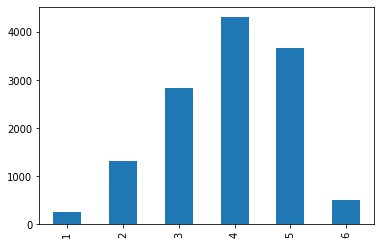

In [14]:
screen['rating'].value_counts().sort_index().plot(kind='bar');

We'll encode a rating of 1 to 3 as negative, and 5 and 6 as positive. Reviews rated 4 will be removed. We'll lose a bit of data this way, but this means that the positive and negative review are a bit more distinct, and will make down stream classification a bit simpler. This leaves us with ~8600 reviews. 

In [15]:
screen = screen.loc[screen['rating']!=4].reset_index(drop=True)
screen['sentiment']=screen['rating'].apply(lambda k: 'positive' if k>=4 else 'negative')
print(screen.shape)
screen.head(3)

(8613, 5)


,filename,rating,title,split,sentiment
0,html/train/000000.html,6,Rome S02,train,positive
1,html/train/000001.html,6,Twin Peaks - definitive gold box edition,train,positive
2,html/train/000002.html,6,The Wire (sesong 1-4),train,positive


The train, validation (dev) and test split is ok:

In [16]:
screen['split'].value_counts(normalize=True)

train    0.803321
dev      0.101707
test     0.094973
Name: split, dtype: float64

And the dataset is well balanced, i.e. similar amount of labels for each class.

In [17]:
screen['sentiment'].value_counts(normalize=True)

negative    0.512713
positive    0.487287
Name: sentiment, dtype: float64

## Add text to the data frame

Let's also add the full text to the dataframe for convenience. This step is not strictly necessary, and doesn't scale to big data. The `html/train` folder contains html files, and the data frame gives us our filenames.

In [18]:
(path/'html/train').ls()

(#28158) [Path('html/train/201232.html'),Path('html/train/601043.html'),Path('html/train/108030.html'),Path('html/train/700390.html'),Path('html/train/702069.html'),Path('html/train/100023.html'),Path('html/train/701430.html'),Path('html/train/201765.html'),Path('html/train/302012.html'),Path('html/train/400836.html')...]

In [19]:
screen.head(3)

,filename,rating,title,split,sentiment
0,html/train/000000.html,6,Rome S02,train,positive
1,html/train/000001.html,6,Twin Peaks - definitive gold box edition,train,positive
2,html/train/000002.html,6,The Wire (sesong 1-4),train,positive


Let's inspect the second file in the data frame. We expect it should be a review of Twin Peaks. We'll open the file and print the raw contents.

In [20]:
fn = screen.loc[1, 'filename']
item = (path/fn)
item

Path('html/train/000001.html')

In [21]:
with open(item) as f: 
    review = f.read()
review[:1500]

'<h1>Twin Peaks - definitive gold box edition</h1>\n\n<p>Tv-serien <em>Twin Peaks</em>, skapt av David Lynch og Mark Frost, trollbandt publikum på starten av 1990-tallet. Nå er begge sesongene samlet på DVD i en såkalt ”definitive gold box edition” som viser at serien ikke har mistet noe av appellen.</p>\n\n<p>Det eneste som egentlig røper alderen, er at serien ikke er i widescreen, og at flere av skuespillerne fremdeles er unge og vakre. 17 år etter premieren har de falmet, som mennesker gjør, men <em>Twin Peaks</em> sikrer dem evig liv.</p>\n\n<h5>Mørke hemmeligheter</h5>\n\n<p>Serien handler om et mordmysterium i den lille byen <em>Twin Peaks</em>, et sted langs USAs grense til Canada. Unge, vakre Laura Palmer blir funnet drept, og FBI-etterforsker Dale Cooper kommer til byen for å oppklare saken.</p>\n\n<p>Her blir han betatt av det tilsynelatende enkle livet i den lille byen mellom den endeløse skogen og de høye fjellene. Men han oppdager også at byen skjuler mørke, farlige hemmel

The data contains normal text but also several html-tags. The REMOVE tag was added by the authors of the dataset to tag unwanted text such as image captions. In general we want to keep our text as intact as possible, but some text is clearly noise. So we'll proceed to get rid of the REMOVE tags and titles. The norec [repo](https://github.com/ltgoslo/norec/blob/master/src/norec/main.py) contains a method to do this with the lxml library. We'll change the code slightly to also remove headers.

In [22]:
from lxml.html import fragments_fromstring

def html_to_text(html): 
    return ' '.join(elem.text_content() for elem in fragments_fromstring(html) if elem.tag == 'p')

In [23]:
html_to_text(review)[:1500]

'Tv-serien Twin Peaks, skapt av David Lynch og Mark Frost, trollbandt publikum på starten av 1990-tallet. Nå er begge sesongene samlet på DVD i en såkalt ”definitive gold box edition” som viser at serien ikke har mistet noe av appellen. Det eneste som egentlig røper alderen, er at serien ikke er i widescreen, og at flere av skuespillerne fremdeles er unge og vakre. 17 år etter premieren har de falmet, som mennesker gjør, men Twin Peaks sikrer dem evig liv. Serien handler om et mordmysterium i den lille byen Twin Peaks, et sted langs USAs grense til Canada. Unge, vakre Laura Palmer blir funnet drept, og FBI-etterforsker Dale Cooper kommer til byen for å oppklare saken. Her blir han betatt av det tilsynelatende enkle livet i den lille byen mellom den endeløse skogen og de høye fjellene. Men han oppdager også at byen skjuler mørke, farlige hemmeligheter. Twin Peaks holder seg overraskende godt. Historien glir nok litt ut i det absurde i sesong 2, mens sesong 1 er en udiskutabel klassiker.

That looks much better! Now lets combine the two methods to make a function to easily get html reviews from a file name

In [24]:
def get_review(fn):
    with open(fn) as f: 
        return(html_to_text(f.read()))

In [25]:
get_review(item)[:1500]

'Tv-serien Twin Peaks, skapt av David Lynch og Mark Frost, trollbandt publikum på starten av 1990-tallet. Nå er begge sesongene samlet på DVD i en såkalt ”definitive gold box edition” som viser at serien ikke har mistet noe av appellen. Det eneste som egentlig røper alderen, er at serien ikke er i widescreen, og at flere av skuespillerne fremdeles er unge og vakre. 17 år etter premieren har de falmet, som mennesker gjør, men Twin Peaks sikrer dem evig liv. Serien handler om et mordmysterium i den lille byen Twin Peaks, et sted langs USAs grense til Canada. Unge, vakre Laura Palmer blir funnet drept, og FBI-etterforsker Dale Cooper kommer til byen for å oppklare saken. Her blir han betatt av det tilsynelatende enkle livet i den lille byen mellom den endeløse skogen og de høye fjellene. Men han oppdager også at byen skjuler mørke, farlige hemmeligheter. Twin Peaks holder seg overraskende godt. Historien glir nok litt ut i det absurde i sesong 2, mens sesong 1 er en udiskutabel klassiker.

Finally we append the review text to our data frame, and save it for future use.

In [26]:
screen['text'] = screen['filename'].apply(lambda o: get_review(path/o))
screen.to_feather(path/'norec_df')
screen.head(3)

,filename,rating,title,split,sentiment,text
0,html/train/000000.html,6,Rome S02,train,positive,"Den andre og siste sesongen av Rome er ute på DVD i Norge. Om du så sesong 1, vet du at du har noe stort i vente. Har du aldri sett Rome før, stikk ut og kjøp begge sesongene. Dette er nemlig en av verdens beste tv-serier, og etter å ha sett de fire første episodene av sesong 2, konstaterer jeg at kvaliteten ser ut til å holde seg på et nesten overraskende høyt nivå! Sesong 2 starter nøyaktig der sesong 1 sluttet. Julius Cæsar ligger myrdet i Senatet og Lucius Vorenus hulker over liket av Neobie. Så blir historien enda mørkere. Marcus Antonius tar over styringen av Roma, men utfordres fra ..."
1,html/train/000001.html,6,Twin Peaks - definitive gold box edition,train,positive,"Tv-serien Twin Peaks, skapt av David Lynch og Mark Frost, trollbandt publikum på starten av 1990-tallet. Nå er begge sesongene samlet på DVD i en såkalt ”definitive gold box edition” som viser at serien ikke har mistet noe av appellen. Det eneste som egentlig røper alderen, er at serien ikke er i widescreen, og at flere av skuespillerne fremdeles er unge og vakre. 17 år etter premieren har de falmet, som mennesker gjør, men Twin Peaks sikrer dem evig liv. Serien handler om et mordmysterium i den lille byen Twin Peaks, et sted langs USAs grense til Canada. Unge, vakre Laura Palmer blir funn..."
2,html/train/000002.html,6,The Wire (sesong 1-4),train,positive,"I neste uke kommer sesong 5 av tv-serien ”The Wire” på DVD. 2008 har for meg vært sterkt preget av denne serien. Hjemme hos oss begynte vi med sesong 1 i vår. Da hadde jeg i lengre tid hørt panegyriske lovord om serien fra både venner og media. Vi ble også fanget av skildringene av purk og skurk i Baltimore, og pløyde oss igjennom alt til og med sesong 4 på sensommeren. Jeg vil ikke gå så langt som å kalle det ”verdens beste serie”, som noen har gjort, men det er ingen tvil om at dette er noe av det bedre som er blitt vist på tv! Serien forteller om en gruppe politietterforskere som samles..."


I will use this dataset in future posts to explore various NLP techniques. In the upcoming post we will see if we are able to train a [ULMFiT](https://nlp.fast.ai/classification/2018/05/15/introducing-ulmfit.html) classifier on this dataset, and see how it compares to the results for the similar english [IMDB-dataset](https://paperswithcode.com/sota/sentiment-analysis-on-imdb). I also hope to test [MultiFiT](https://nlp.fast.ai/classification/2019/09/10/multifit.html) in a later post.